In [2]:
# import the necessary library
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import time
import warnings
import pandas as pd

In [3]:
# get the MNIST dataset
mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

# Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=100000, solver='saga')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9214


GridSearchCV

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


import cuml
print("RAPIDS cuML version:", cuml.__version__)

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 9.74 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 12.12s
  × Failed to download `libcuvs-cu12==25.4.0`
  ├─▶ Failed to fetch:
  │   `https://pypi.nvidia.com/libcuvs-cu12/libcuvs_cu12-25.4.0-py3-none-manylinux_2_28_x86_64.whl`
  ├─▶ error sending request for url
  │   (https://pypi.nvidia.com/libcuvs-cu12/libcuvs_cu12-25.4.0-py3-none-manylinux_2_28_x86_64.whl)
  ├─▶ client error (SendRequest)
  ├─▶ http2 error
  ╰─▶ connection error detected: flow-control protocol violated
  help: `libcuvs-cu12` (v25.4.0) was included because `cuml-cu12` (v25.4.0)
        depends on `cuvs-cu1

In [4]:
try:
    import cupy as cp
    import cudf
    from cuml.preprocessing import MinMaxScaler as cuMinMaxScaler
    from cuml.linear_model import LogisticRegression as cuLogisticRegression
    from cuml.pipeline import Pipeline as cuPipeline
    from cuml.model_selection import GridSearchCV as cuGridSearchCV
    import cuml.metrics
    RAPIDS_AVAILABLE = True
    print("RAPIDS cuML libraries imported successfully.")
except ImportError as e:
    warnings.warn(f"RAPIDS cuML not found. Running on CPU with scikit-learn. Error: {e}")
    from sklearn.preprocessing import MinMaxScaler as skMinMaxScaler
    from sklearn.linear_model import LogisticRegression as skLogisticRegression
    from sklearn.pipeline import Pipeline as skPipeline
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
    RAPIDS_AVAILABLE = False

try:
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
except Exception as e:
    print(f"Failed fetching with liac-arff parser, trying default: {e}")
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data.astype(np.float32)
y = mnist.target.astype(np.int32)
X = X / 255.0

# Split data
X_train_gpu, y_train_gpu = X[:60000], y[:60000]
X_test_gpu, y_test_gpu = X[60000:], y[60000:]

print(f"CPU Data shapes: X_train={X_train_gpu.shape}, y_train={y_train_gpu.shape}")
print(f"CPU Data types: X_train={X_train_gpu.dtype}, y_train={y_train_gpu.dtype}")

if RAPIDS_AVAILABLE:
    print("Using cuML components:")
    ScalerClass = cuMinMaxScaler
    LogisticRegressionClass = cuLogisticRegression
    PipelineClass = cuPipeline
    GridSearchCVClass = cuGridSearchCV
    # -----------------------------------------
    logistic_params = {
        'penalty': 'l2', 'solver': 'qn', 'max_iter': 10000, 'tol': 1e-3
    }
    grid_search_extra_params = {}
    print(f"   Scaler: {ScalerClass}")
    print(f"   Pipeline: {PipelineClass}")
    print(f"   LogisticRegression: {LogisticRegressionClass}")
    print(f"   GridSearchCV: {GridSearchCVClass}")

else:
    print("Using scikit-learn components:")
    ScalerClass = skMinMaxScaler
    LogisticRegressionClass = skLogisticRegression
    PipelineClass = skPipeline
    GridSearchCVClass = skGridSearchCV
    logistic_params = {
        'random_state': 42, 'solver': 'saga', 'max_iter': 10000,
        'penalty': 'l2', 'tol': 1e-3
    }
    grid_search_extra_params = {'n_jobs': -1}
    print(f"   Scaler: {ScalerClass}")
    print(f"   Pipeline: {PipelineClass}")
    print(f"   LogisticRegression: {LogisticRegressionClass}")
    print(f"   GridSearchCV: {GridSearchCVClass}")


pipe_lr = PipelineClass([
    ('scaler', ScalerClass()),
    ('logisticregression', LogisticRegressionClass(**logistic_params))
])


param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorer = 'accuracy'

# Instantiate GridSearchCV using the dynamically assigned GridSearchCVClass
grid_search = GridSearchCVClass(
    estimator=pipe_lr,
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    verbose=1,
    **grid_search_extra_params
)

start_time = time.time()

if RAPIDS_AVAILABLE:
    print(f"GPU Data shapes: X_train={X_train_gpu.shape}, y_train={y_train_gpu.shape}")
    print(f"GPU Data types: X_train={X_train_gpu.dtype}, y_train={y_train_gpu.dtype}")

    print("\nStarting cuML GridSearchCV on GPU...")
    try:
        # FIT THE MODEL (Now using cuML GridSearchCV with cuML Pipeline and CuPy data)
        grid_search.fit(X_train_gpu, y_train_gpu)
        print("cuML GridSearchCV finished.")

    except TypeError as e:
        import traceback
        print(f"\nCaught TypeError during grid_search.fit:\n{e}")
        print("\nFull Traceback:")
        traceback.print_exc()
        print("\nIf this persists, it might indicate a deeper issue or version mismatch.")
    except Exception as e:
        import traceback
        print(f"\nCaught an unexpected error during grid_search.fit:\n{e}")
        print("\nFull Traceback:")
        traceback.print_exc()

else:
    print("\nStarting scikit-learn GridSearchCV on CPU...")
    grid_search.fit(X_train_gpu, y_train_gpu)
    print("scikit-learn GridSearchCV finished.")

end_time = time.time()
print(f"\nGridSearchCV execution time: {end_time - start_time:.2f} seconds")

# --- 4. Display Results ---
if hasattr(grid_search, 'best_params_') and hasattr(grid_search, 'best_score_'):
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    if RAPIDS_AVAILABLE and hasattr(best_score, 'item'):
        best_score = best_score.item()
    print(f"\nBest parameters found: {best_params}")
    print(f"Best cross-validation accuracy score: {best_score:.4f}")
else:
    print("\nGridSearchCV fitting may not have completed successfully. Results unavailable.")

# --- 5. Clean up GPU memory ---
if RAPIDS_AVAILABLE:
    try:
        del X_train_gpu, y_train_gpu
        cp.get_default_memory_pool().free_all_blocks()
        print("GPU memory cleared.")
    except NameError:
        print("GPU variables not found for cleanup.")

RAPIDS cuML libraries imported successfully.
CPU Data shapes: X_train=(60000, 784), y_train=(60000,)
CPU Data types: X_train=float32, y_train=int32
Using cuML components:
   Scaler: <class 'cuml._thirdparty.sklearn.preprocessing._data.MinMaxScaler'>
   Pipeline: <class 'sklearn.pipeline.Pipeline'>
   LogisticRegression: <class 'cuml.linear_model.logistic_regression.LogisticRegression'>
   GridSearchCV: <class 'sklearn.model_selection._search.GridSearchCV'>
GPU Data shapes: X_train=(60000, 784), y_train=(60000,)
GPU Data types: X_train=float32, y_train=int32

Starting cuML GridSearchCV on GPU...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
cuML GridSearchCV finished.

GridSearchCV execution time: 37.37 seconds

Best parameters found: {'logisticregression__C': 0.1}
Best cross-validation accuracy score: 0.9207
GPU memory cleared.


In [ ]:
# Logistic Regression without PCA
default_pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42, solver='saga', C=0.1))
default_pipe.fit(X_train, y_train)
y_pred = default_pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Logistic Regression without PCA: {accuracy:.4f}")

Accuracy for Logistic Regression without PCA: 0.9258


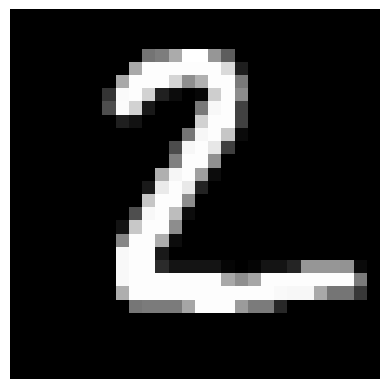

Predicted Label: 2


In [ ]:
# Test the classifier with an actual instance
# Reshape the instance to plot
image = X_test[1].reshape(28, 28)

# Plot the image
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

# Select one instance to predict
instance = X_test[1].reshape(1, -1)  # Reshape to keep it 2D for the model

# Predict the label
predicted_label = default_pipe.predict(instance)

print(f"Predicted Label: {predicted_label[0]}")

# Logistic Regression with Dimensionality Reduction

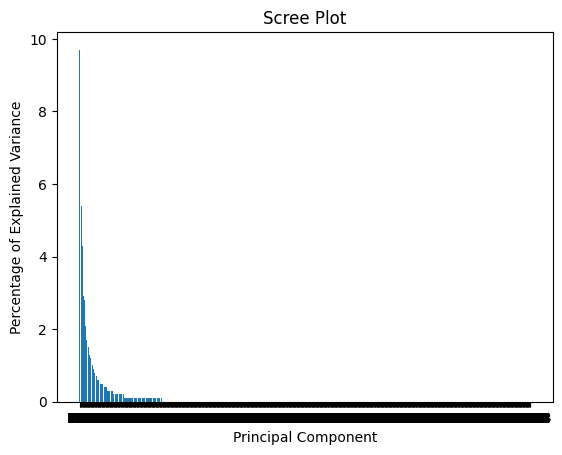

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [ ]:
# Initialize a PCA and reduce the dimesion of the original dataset
pca = PCA(n_components=0.95) # We keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier (Logistic Regression)
pca_clf = LogisticRegression(max_iter=100000, random_state=42, solver='saga')

pca_clf.fit(X_train_pca, y_train)

# Predict and compute accuracy
y_pred = pca_clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy after PCA with {pca.n_components_} components: {accuracy:.4f}")

Accuracy after PCA with 154 components: 0.9204


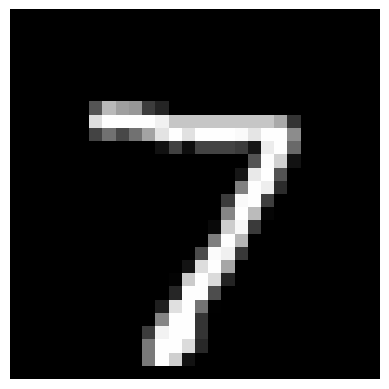

Predicted Label: 7


In [ ]:
# Test the classifier with an actual instance
# Reshape the instance to plot
image = X_test[0].reshape(28, 28)

# Plot the image
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

# Select one instance to predict
instance = X_test_pca[0].reshape(1, -1)  # Reshape to keep it 2D for the model

# Predict the label
predicted_label = pca_clf.predict(instance)

print(f"Predicted Label: {predicted_label[0]}")

# K-Means

In [ ]:
k = 2100
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

In [ ]:
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]
y_representative_digits = y_train[representative_digit_idx]

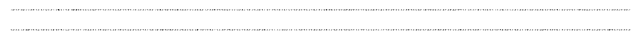

In [ ]:
# extra code – this cell generates and saves Figure 9–13

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 250, 250, index + 1)
    plt.imshow(X_representative_digit.reshape(28, 28), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [ ]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8793

In [ ]:
log_reg.predict(X_test[1].reshape(1, -1))

array(['2'], dtype=object)

# Support Vector Machine w/ Gaussian RBF Kernel

**StandardScaler**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(y_pred)
print(y_test)
print(accuracy)

['1' '1' '1' ... '1' '1' '1']
['7' '2' '1' ... '4' '5' '6']
0.1135


**MinMaxScaler**

In [ ]:
rbf_kernel_svm_clf2 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf2.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
y_pred2 = rbf_kernel_svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print(y_pred2)
print(y_test)
print(accuracy)

['1' '1' '1' ... '1' '1' '1']
['7' '2' '1' ... '4' '5' '6']
0.1135


**Another Gamma and C values**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=1))
])
rbf_kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm_clf', SVC(C=1, gamma=0.1))])

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print(y_test)
print(accuracy)

['7' '2' '1' ... '4' '5' '6']
['7' '2' '1' ... '4' '5' '6']
0.955


In [ ]:
# Test gamma với C khác thử.
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X_train, y_train)
    svm_clfs.append(rbf_kernel_svm_clf)

**Linear Kernel**

In [ ]:
linear_svm_clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("linear_svc", SVC(kernel="linear", C=1))
])
linear_svm_clf.fit(X_train, y_train)

**Polynomial Kernel**

In [ ]:
polynomial_svm_clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
polynomial_svm_clf.fit(X_train, y_train)

**Grid Search**

In [ ]:
# Define hyperparameter grid for Linear SVM
param_grid_linear = {'C': np.logspace(-3, 3, 7)}


# Perform Grid Search for Linear SVM
grid_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
grid_linear.fit(X_train, y_train)
best_curr_C_linear = grid_linear.best_params_['C']


print(f"Best C for Linear SVM: {best_curr_C_linear}")
print(f"Best CV Accuracy for Linear SVM: {grid_linear.best_score_:.4f}")


In [ ]:
# Define hyperparameter grid for Polynomial Kernel SVM
param_grid_poly = {
    'C': np.logspace(-3, 3, 7),
    'degree': [2, 3, 4, 5],
    'coef0': [0, 0.5, 1, 2]
}

# Perform Grid Search for Polynomial Kernel SVM
grid_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5, scoring='accuracy', n_jobs=-1)
grid_poly.fit(X_train, y_train)
best_params_poly = grid_poly.best_params_

# Best parameters
best_curr_C_poly = best_params_poly['C']
best_curr_degree = best_params_poly['degree']
best_curr_coef0 = best_params_poly['coef0']

print(f"Best C for Polynomial SVM: {best_curr_C_poly}")
print(f"Best Degree for Polynomial SVM: {best_curr_degree}")
print(f"Best Coef0 for Polynomial SVM: {best_curr_coef0}")
print(f"Best CV Accuracy for Polynomial SVM: {grid_poly.best_score_:.4f}")
